# Gegevens inladen en folders inladen

In [1]:
# Cell 2: setup imports and repo discovery
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pastas as ps


warnings.filterwarnings('ignore')
# find repo root
repo_root = Path.cwd()
for candidate in [repo_root] + list(repo_root.parents):
    if (candidate / 'pyproject.toml').exists() or (candidate / '.git').exists():
        repo_root = candidate
        break
print('Repo root:', repo_root)

wiertsema_dir = repo_root / 'output_data' / 'only_csv_wiertsema'
fugro_dir = repo_root / 'output_data' / 'only_csv_fugro'    
singles_dir = repo_root / 'output_data' / 'only_csv_singles'
stressor_dir = repo_root / 'input_stressors'
out_fig = repo_root / 'output_data' / 'figures'
models_folder = repo_root / 'output_data' / 'models'
out_fig.mkdir(parents=True, exist_ok=True)

Repo root: d:\Users\jvanruitenbeek\data_validation


In [2]:
# Name of the directory containing single well data
#name_model = "NL-241417-ET-20011012_HB27-PB1_0.16_-0.84_m_NAP_avg"

# --- Load and clean the head data ---------------------------------------------
# df_head = pd.read_csv(
#     Path(fugro_dir) / (name_model + ".csv"),
#     index_col=0,
#     parse_dates=True,
#     encoding="utf-8-sig"
# )

# Take first numeric column and rename to 'head'
#head = df_head.select_dtypes("number").iloc[:, 0].rename("head")

# Crop to first and last valid (non-NaN) data points
#df_head = head.loc[head.first_valid_index(): head.last_valid_index()]

df_prec = pd.read_csv(Path(stressor_dir) / "prec_station_249_2020.csv",
                   index_col=0, parse_dates=True)["Precipitation"]

df_evap = pd.read_csv(Path(stressor_dir) / "evap_station_249_2020.csv",
                   index_col=0, parse_dates=True)["ET"]

df_prec_long = pd.read_csv(Path(stressor_dir) / "precipitation_long_clean.csv",
                   index_col=0, parse_dates=True)["precipitation"]

df_evap_long = pd.read_csv(Path(stressor_dir) / "evaporation_long_clean.csv",
                   index_col=0, parse_dates=True)["evaporation"]

# Model Inladen 

### Code voor Tarso Model

In [3]:
# model_name = "WG_BE0341+40_BIT_GMW_PB1_F-616_tarso_model.pas"
# model_path = models_folder / model_name

# ml = ps.io.load(model_path)
# p_solved = ml.get_parameters()

# ########## Current climate ##############
# ml_cc = ml.copy(name="climate_timeseries")
# ml_cc.del_stressmodel("Tarso")

# sm = ps.TarsoModel(
#     df_prec_long,
#     df_evap_long,
#     dmin = ml_cc.oseries.series.quantile(0.05),
#     dmax = ml_cc.oseries.series.quantile(0.95)
# )
# ml_cc.add_stressmodel(sm)
# simulated = ml_cc.simulate(
#     p=p_solved, tmin="1906", tmax="2015", freq="D", warmup=3650, return_warmup=False
# )

### Code voor Non-Lineair Model

In [4]:
model_name = "WG_BE0049+00_INST_B_GMW_PB1_F-365_non_linear_model.pas"
model_path = models_folder / model_name

ml = ps.io.load(model_path)
p_solved = ml.get_parameters()

The Time Series 'head' has nan-values. Pastas will use the fill_nan settings to fill up the nan-values.


In [5]:
########## Current climate ##############
ml_cc = ml.copy(name="climate_timeseries")

# Picking a recharge model with a non-linear recharge
rch = ps.rch.FlexModel(gw_uptake=True) 

# Define the stressmodel with a Gamma response function
sm  = ps.RechargeModel(
    df_prec_long,
    df_evap_long,
    recharge=rch,
    rfunc=ps.DoubleExponential(),
    # name="recharge"      # <- Gamma response function
)

# Adding stressmodel to current climate model
ml_cc.add_stressmodel(sm)

# Adding threshold transform
#ml_cc.add_transform(ps.ThresholdTransform())

simulated = ml_cc.simulate(
    p=p_solved, tmin="1906", tmax="2015", freq="D", warmup=3650, return_warmup=False
)

The Time Series 'head' has nan-values. Pastas will use the fill_nan settings to fill up the nan-values.
The name for the stressmodel you are trying to add already exists for this model. The stressmodel is replaced.
The stress of the stressmodel has no overlap with ml.oseries.


# Plot to validate the results

In [6]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def clean_series(s, name):
    if not isinstance(s, pd.Series):
        # accept 1-column DataFrame too
        if isinstance(s, pd.DataFrame) and s.shape[1] == 1:
            s = s.iloc[:, 0]
        else:
            raise TypeError(f"{name} must be a Series or 1-column DataFrame")
    s = pd.to_numeric(s, errors="coerce")
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s.dropna()
    s.name = name
    return s

# Inputs -> tidy Series
sim  = clean_series(simulated,      "Simulated head")
prec = clean_series(df_prec_long,   "Precipitation")
evap = clean_series(df_evap_long,   "Evaporation")

# Align to a common overlapping window so everything is visible together
start = max(sim.index.min(), prec.index.min(), evap.index.min())
end   = min(sim.index.max(), prec.index.max(), evap.index.max())
sim   = sim.loc[start:end]
prec  = prec.loc[start:end]
evap  = evap.loc[start:end]

# Optional: if sim is hourly and P/E are daily, you may want to aggregate head to daily
# sim = sim.resample("D").mean()

# Recharge = precipitation - evaporation
recharge = (prec - evap).rename("Recharge")

# Build figure
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Head: solid black on primary axis
fig.add_trace(
    go.Scatter(x=sim.index, y=sim.values, mode="lines",
               name="Simulated head", line=dict(color="black")),
    secondary_y=False
)

# Hydro lines on secondary axis
fig.add_trace(
    go.Scatter(x=prec.index, y=prec.values, mode="lines",
               name="Precipitation", opacity=0.7),
    secondary_y=True
)
fig.add_trace(
    go.Scatter(x=evap.index, y=evap.values, mode="lines",
               name="Evaporation", opacity=0.7),
    secondary_y=True
)
fig.add_trace(
    go.Scatter(x=recharge.index, y=recharge.values, mode="lines",
               name="Recharge", opacity=0.9),
    secondary_y=True
)

# Minimal layout: no range slider/selector
fig.update_layout(
    title= model_name,
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
    margin=dict(l=60, r=40, t=50, b=40)
)
fig.update_xaxes(rangeslider=dict(visible=False))
fig.update_yaxes(title_text="Head", secondary_y=False)
fig.update_yaxes(title_text="P / E / Recharge", secondary_y=True)

fig.show()

# Enkele tijdreeksen welke interessant zijn

- NL-241417-ET-21072016_B12-PB1_0.54_-0.46_m_NAP_avg.csv
- NL-241417-ET-21070919_HB25-PB1_0.60_-0.39_m_NAP_avg.csv
- NL-241417-ET-20011012_HB27-PB1_0.16_-0.84_m_NAP_avg.csv
- NL-241417-ET-21120911_B14-PB1_-4.95_-5.95_m_NAP_avg.csv
- NL-241417-ET-22033044_B26-PB1_-4.82_-5.82_m_NAP_avg.csv

<class 'pandas.core.series.Series'>
DatetimeIndex: 39813 entries, 1906-01-01 to 2015-01-01
Freq: D
Series name: Simulation
Non-Null Count  Dtype  
--------------  -----  
39813 non-null  float64
dtypes: float64(1)
memory usage: 622.1 KB


<Axes: >

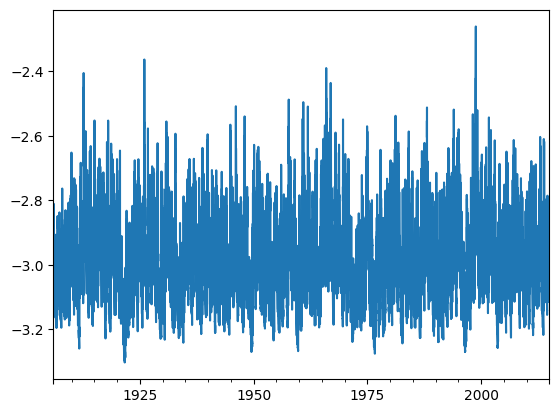

In [7]:
simulated.info()
simulated.plot()

# Selecteren hoogste en laagste grondwaterstanden

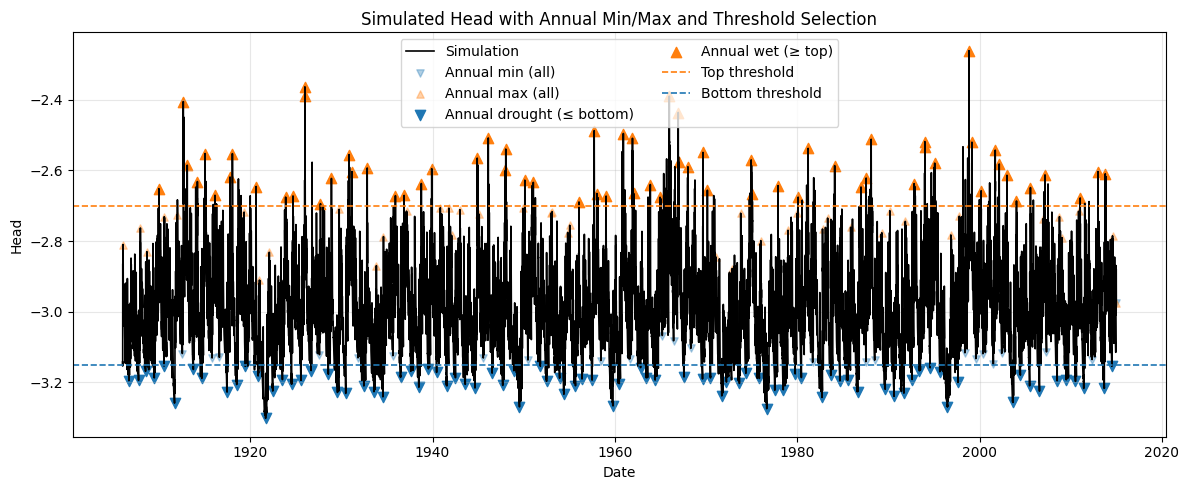

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- settings: set your thresholds here -----------------
top_threshold = -2.7      # maxima ≥ this go into df_annual_wet
bottom_threshold = -3.15  # minima ≤ this go into df_annual_drought
# ----------------------------------------------------------------------

# --- Clean input into a Series with DatetimeIndex ---
sim = simulated if isinstance(simulated, pd.Series) else simulated.iloc[:, 0]
sim = pd.to_numeric(sim, errors="coerce").dropna()
if not isinstance(sim.index, pd.DatetimeIndex):
    sim.index = pd.to_datetime(sim.index, errors="coerce")
sim = sim.sort_index()
sim.name = sim.name or "Simulated head"

# --- Annual extrema using GroupBy + Grouper (calendar years) ---
grp = sim.groupby(pd.Grouper(freq="Y"))
idx_min = grp.apply(pd.Series.idxmin)
idx_max = grp.apply(pd.Series.idxmax)

# Build DataFrames with the occurrence date as the index
annual_min_df = pd.DataFrame(
    {"annual_min": sim.loc[idx_min.values].values},
    index=idx_min.values
)
annual_max_df = pd.DataFrame(
    {"annual_max": sim.loc[idx_max.values].values},
    index=idx_max.values
)
annual_min_df["year"] = annual_min_df.index.year
annual_max_df["year"] = annual_max_df.index.year

# ----------------- rename + threshold-filtered copies -----------------
# Renamed DataFrames (unfiltered)
df_annual_drought_all = annual_min_df.rename(columns={"annual_min": "head_min"})
df_annual_wet_all     = annual_max_df.rename(columns={"annual_max": "head_max"})

# Filtered by thresholds (these are the ones you asked for)
df_annual_drought = df_annual_drought_all[df_annual_drought_all["head_min"] <= bottom_threshold].copy()
df_annual_wet     = df_annual_wet_all[df_annual_wet_all["head_max"] >= top_threshold].copy()
# ----------------------------------------------------------------------

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(sim.index, sim.values, color="black", lw=1.2, label=sim.name)

# All yearly minima/maxima as faint markers
ax.scatter(df_annual_drought_all.index, df_annual_drought_all["head_min"],
           marker="v", s=28, color="tab:blue", alpha=0.35, label="Annual min (all)")
ax.scatter(df_annual_wet_all.index, df_annual_wet_all["head_max"],
           marker="^", s=28, color="tab:orange", alpha=0.35, label="Annual max (all)")

# Highlight the threshold-selected points
ax.scatter(df_annual_drought.index, df_annual_drought["head_min"],
           marker="v", s=55, color="tab:blue", label="Annual drought (≤ bottom)")
ax.scatter(df_annual_wet.index, df_annual_wet["head_max"],
           marker="^", s=55, color="tab:orange", label="Annual wet (≥ top)")

# Threshold lines
ax.axhline(y=top_threshold,     color="tab:orange", linestyle="--", linewidth=1.2, label="Top threshold")
ax.axhline(y=bottom_threshold,  color="tab:blue",   linestyle="--", linewidth=1.2, label="Bottom threshold")

ax.set_title("Simulated Head with Annual Min/Max and Threshold Selection")
ax.set_xlabel("Date")
ax.set_ylabel("Head")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

# The two DataFrames you’ll use:
# - df_annual_drought : minima with head ≤ bottom_threshold (index = occurrence date)
# - df_annual_wet     : maxima with head ≥ top_threshold     (index = occurrence date)

# Optional: quick check
# print(df_annual_drought.head())
# print(df_annual_wet.head())

# Selecting Minima and Maxima

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto, genextreme

def fit_tail_plot(df: pd.DataFrame,
                  col: str,
                  kind: str,                # 'min' or 'max'
                  ax=None,
                  title: str | None = None):
    """
    Fit GPD, GEV, and exponential (GPD with c=0) to annual extrema and plot histogram + PDFs.
    - For minima: flips sign (data_fit = -values) so the lower tail becomes a positive upper tail.
    - For maxima: uses the raw values as the positive upper tail.
    Returns a dict with fitted params and the axis.
    """
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not in df")

    vals = pd.to_numeric(df[col], errors="coerce").dropna().values
    if vals.size < 5:
        raise ValueError("Need at least 5 data points to fit distributions.")

    is_min = (kind.lower().startswith("min"))
    # Map to a positive upper-tail variable
    if is_min:
        data_fit = -vals
        x_plot_transform = lambda x: -x  # map back to original units for plotting
        hist_data = -data_fit            # plot histogram in original units
        x_label = "Groundwater head (minima)"
        base_title = "Annual Drought (minima)"
    else:
        data_fit = vals
        x_plot_transform = lambda x: x
        hist_data = data_fit             # already in original units
        x_label = "Groundwater head (maxima)"
        base_title = "Annual Wet (maxima)"

    # axis
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))

    # Histogram (original units)
    ax.hist(hist_data, density=True, bins="auto",
            histtype="stepfilled", alpha=0.2, color="red",
            label=f"{base_title} (hist)")

    # --- GPD fit ---
    # Ensure non-negative support by fixing loc to min of data_fit
    loc0 = data_fit.min()
    c_gpd, loc_gpd, scale_gpd = genpareto.fit(data_fit, floc=loc0)

    x = np.linspace(data_fit.min(), data_fit.max(), 400)
    pdf_gpd = genpareto.pdf(x, c_gpd, loc=loc_gpd, scale=scale_gpd)
    ax.plot(x_plot_transform(x), pdf_gpd, "r-", lw=2, label=f"GPD (c={c_gpd:.3f})")

    # --- GEV fit ---
    c_gev, loc_gev, scale_gev = genextreme.fit(data_fit)
    pdf_gev = genextreme.pdf(x, c_gev, loc=loc_gev, scale=scale_gev)
    ax.plot(x_plot_transform(x), pdf_gev, "k-", lw=2, label=f"GEV (c={c_gev:.3f})")

    # --- Exponential (GPD with c=0) ---
    y = data_fit - data_fit.min()   # shift to 0
    scale_exp = y.mean()            # MLE for exponential scale with loc fixed
    c_exp, loc_exp = 0.0, data_fit.min()
    pdf_exp = genpareto.pdf(x, c_exp, loc=loc_exp, scale=scale_exp)
    ax.plot(x_plot_transform(x), pdf_exp, "g-", lw=2, label="Exponential (c=0)")

    ax.set_title(title or base_title + " — Tail Fits")
    ax.set_xlabel(x_label)
    ax.set_ylabel("Density")
    ax.grid(alpha=0.3)
    ax.legend()

    # Print parameters for quick inspection
    print(f"[{base_title}]")
    print(f"  GPD: c={c_gpd:.4f}, scale={scale_gpd:.4f}, loc={loc_gpd:.4f}")
    print(f"  GEV: c={c_gev:.4f}, scale={scale_gev:.4f}, loc={loc_gev:.4f}")
    print(f"  EXP: c={c_exp:.4f}, scale={scale_exp:.4f}, loc={loc_exp:.4f}")

    return {
        "gpd": (c_gpd, loc_gpd, scale_gpd),
        "gev": (c_gev, loc_gev, scale_gev),
        "exp": (c_exp, loc_exp, scale_exp),
        "ax": ax,
    }

def fit_both(df_annual_drought: pd.DataFrame,
             df_annual_wet: pd.DataFrame,
             col_min: str = "head_min",
             col_max: str = "head_max"):
    """
    Convenience wrapper: plot + fit minima and maxima side-by-side.
    Returns {'min': result_min, 'max': result_max}.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5), constrained_layout=True)

    res_min = fit_tail_plot(df_annual_drought, col=col_min, kind="min", ax=ax1,
                            title="Annual Drought (minima) — Tail Fits")
    res_max = fit_tail_plot(df_annual_wet,     col=col_max, kind="max", ax=ax2,
                            title="Annual Wet (maxima) — Tail Fits")

    return {"min": res_min, "max": res_max}

In [10]:
df_annual_drought.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86 entries, 1906-09-10 to 2014-07-05
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   head_min  86 non-null     float64
 1   year      86 non-null     int32  
dtypes: float64(1), int32(1)
memory usage: 1.7 KB


In [11]:
df_annual_wet.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 1909-12-24 to 2013-10-14
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   head_max  68 non-null     float64
 1   year      68 non-null     int32  
dtypes: float64(1), int32(1)
memory usage: 1.3 KB


[Annual Drought (minima)]
  GPD: c=-0.4201, scale=0.0666, loc=3.1542
  GEV: c=0.0405, scale=0.0251, loc=3.1887
  EXP: c=0.0000, scale=0.0481, loc=3.1542
[Annual Wet (maxima)]
  GPD: c=-0.1992, scale=0.1272, loc=-2.6942
  GEV: c=-0.2629, scale=0.0522, loc=-2.6333
  EXP: c=0.0000, scale=0.1063, loc=-2.6942


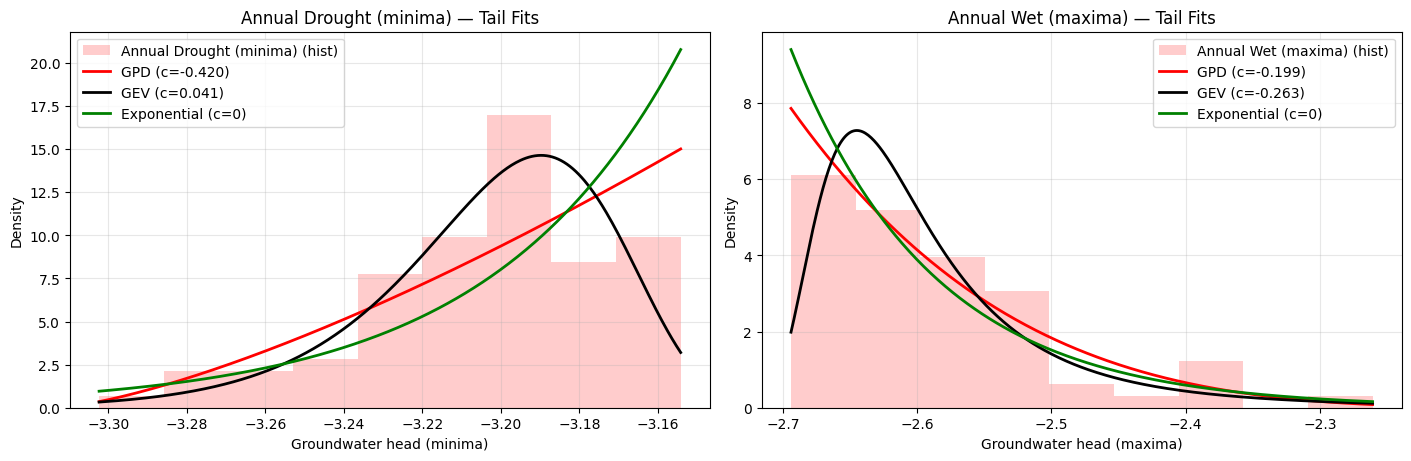

In [12]:
# Assuming you already have:
#   df_annual_drought with column 'head_min'
#   df_annual_wet     with column 'head_max'

results = fit_both(df_annual_drought, df_annual_wet, col_min="head_min", col_max="head_max")

# Access parameters, e.g.:
gpd_min_params = results["min"]["gpd"]  # (c, loc, scale) for minima
gev_max_params = results["max"]["gev"]  # (c, loc, scale) for maxima

In [13]:
def get_mins_pot(df, thresh=0.1, window=30):
    df = -df
    extremes = get_extremes(df, "POT", threshold=df.quantile(thresh), r=f"{window}D")
    minima = -extremes

    b_plot = 0.44
    T_per = (df.index[-1] - df.index[0]).total_seconds() / 3600 / 24 / 365
    h_pot = minima.sort_values(ascending=False)
    T_pot = np.flip(
        calc_return_period_pot(h_pot, Tper=T_per, a=b_plot, b=(1 - 2 * b_plot))
    )

    return minima, T_per, T_pot, h_pot


def calc_return_period_pot(maxima, Tper, a=0.3, b=0.4, n=None):
    # Sort peak values in descending order
    order = np.argsort(maxima)[::-1]
    maxima = np.sort(maxima)[::-1]

    # If not provided, use the full length of maxima
    if n is None:
        n = len(maxima)

    # Compute plotting positions
    k = np.arange(len(maxima)) + 1
    P = (n * (k + a + b - 1)) / ((n + b) * Tper)  # Probability of exceedance
    T = 1.0 / P  # Return period (years)

    return T[np.argsort(order)]  # Restore original order


def give_vfit_ffit_exp(minima, T_per, Ts, hs, Tthresh):
    minima = -minima
    hs = -hs

    mask = Ts > Tthresh
    params = expon.fit(hs[mask])  # fit exonentiele verdeling

    pfit = np.exp(np.arange(np.log(1e-5), np.log(1), 0.1))  # maak kansen raster
    vfit = expon.ppf(
        1 - pfit, *params
    )  # geeft de geschatte waarde bij de opgegeven overschrijdingskansen
    ffit = pfit * (
        len(hs[mask]) / T_per
    )  # schaling van de extreme waarde verdeling door freqenties aan te passen

    fnew = pfit
    df_freq = pd.DataFrame(index=ffit, data=vfit, columns=["headvalues"]).dropna()
    vnew = bepaal_hoogte(df_freq.index.values, df_freq.headvalues.values, fnew)
    vnew = -vnew
    return vnew, fnew, params


def give_vfit_ffit_gpv(minima, T_per, Ts, hs, Tthresh):
    minima = -minima
    hs = -hs

    mask = Ts > Tthresh
    params = genpareto.fit(hs[mask], floc=min(data_fit))

    pfit = np.exp(np.arange(np.log(1e-5), np.log(1), 0.1))  # maak kansen raster
    vfit = genpareto.ppf(1 - pfit, *params)
    ffit = pfit * (len(hs[mask]) / T_per)

    fnew = pfit
    df_freq = pd.DataFrame(index=ffit, data=vfit, columns=["headvalues"]).dropna()
    vnew = bepaal_hoogte(df_freq.index.values, df_freq.headvalues.values, fnew)
    vnew = -vnew
    return vnew, fnew, params


def give_vfit_ffit_gev(minima, T_per, Ts, hs, Tthresh):
    minima = minima
    hs = hs

    mask = Ts > Tthresh
    params = genextreme.fit(
        hs[mask]
    )  # f0=-0.3, floc=10620, scale=300)#, -.8, loc=10480, scale=300)
    pfit = np.exp(np.arange(np.log(1e-5), np.log(1), 0.1))
    vfit = genextreme.ppf(pfit, *params)
    ffit = pfit * (len(hs[mask]) / T_per)

    fnew = pfit
    df_freq = pd.DataFrame(index=ffit, data=vfit, columns=["headvalues"]).dropna()
    vnew = bepaal_hoogte(df_freq.index.values, df_freq.headvalues.values, fnew)
    vnew = vnew
    return vnew, fnew, params


def bepaal_hoogte(fp, xp, f):
    fint = interp1d(np.log(fp), xp, fill_value="extrapolate")
    return fint(np.log(f))

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto, genextreme

def rp_weibull(n: int) -> np.ndarray:
    """Weibull plotting position: P = k/(n+1), T = 1/P (years)."""
    k = np.arange(1, n + 1, dtype=float)
    P = k / (n + 1.0)
    return 1.0 / P

def plot_empirical_and_fits_min(ax, mins, color="tab:blue", label_prefix="Min"):
    """Empirical minima + fitted Exp/GPD/GEV (minima treated as lower tail)."""
    y = pd.to_numeric(mins, errors="coerce").dropna().values
    if y.size < 5:
        raise ValueError("Need at least 5 annual minima.")

    # Sort by extremeness: lower = more extreme
    y_sort = np.sort(y)                # ascending heads
    T_emp = rp_weibull(len(y_sort))    # match the same order

    # Flip to model lower tail as upper tail
    z = -y_sort
    z0 = z.min()
    f_grid = np.exp(np.linspace(np.log(1e-5), 0, 400))
    T_grid = 1.0 / f_grid

    # Exponential (GPD c=0) with loc=z0
    scale_exp = (z - z0).mean()
    v_exp = -genpareto.ppf(1 - f_grid, c=0.0, loc=z0, scale=scale_exp)

    # GPD (loc fixed to z0)
    c_gpd, loc_gpd, scale_gpd = genpareto.fit(z, floc=z0)
    v_gpd = -genpareto.ppf(1 - f_grid, c=c_gpd, loc=loc_gpd, scale=scale_gpd)

    # GEV (unconstrained)
    c_gev, loc_gev, scale_gev = genextreme.fit(z)
    v_gev = -genextreme.ppf(1 - f_grid, c=c_gev, loc=loc_gev, scale=scale_gev)

    # Plot
    ax.plot(T_emp, y_sort, "x", ms=3, color=color, alpha=1, label=f"Empirical {label_prefix.lower()} (N={len(y_sort)})")
    ax.plot(T_grid, v_exp, color=color, lw=2, alpha=0.5, label=f"{label_prefix}: Exp (c=0)")
    ax.plot(T_grid, v_gpd, color=color, lw=2, alpha=0.5, ls="--", label=f"{label_prefix}: GPD (c={c_gpd:.2f})")
    ax.plot(T_grid, v_gev, color=color, lw=2, alpha=0.5, ls=":",  label=f"{label_prefix}: GEV (c={c_gev:.2f})")

def plot_empirical_and_fits_max(ax, maxs, color="tab:orange", label_prefix="Max"):
    """Empirical maxima + fitted Exp/GPD/GEV (upper tail)."""
    y = pd.to_numeric(maxs, errors="coerce").dropna().values
    if y.size < 5:
        raise ValueError("Need at least 5 annual maxima.")

    # Sort by extremeness: higher = more extreme
    y_sort = np.sort(y)[::-1]          # descending heads
    T_emp = rp_weibull(len(y_sort))    # match the same order

    # Upper tail as-is
    z = y_sort
    z0 = z.min()
    f_grid = np.exp(np.linspace(np.log(1e-5), 0, 400))
    T_grid = 1.0 / f_grid

    # Exponential (GPD c=0) with loc=z0
    scale_exp = (z - z0).mean()
    v_exp = genpareto.ppf(1 - f_grid, c=0.0, loc=z0, scale=scale_exp)

    # GPD (loc fixed to z0)
    c_gpd, loc_gpd, scale_gpd = genpareto.fit(z, floc=z0)
    v_gpd = genpareto.ppf(1 - f_grid, c=c_gpd, loc=loc_gpd, scale=scale_gpd)

    # GEV (unconstrained)
    c_gev, loc_gev, scale_gev = genextreme.fit(z)
    v_gev = genextreme.ppf(1 - f_grid, c=c_gev, loc=loc_gev, scale=scale_gev)

    # Plot
    ax.plot(T_emp, y_sort, "x", ms=3, color=color, alpha=1, label=f"Empirical {label_prefix.lower()} (N={len(y_sort)})")
    ax.plot(T_grid, v_exp, color=color, lw=2, alpha=0.5, label=f"{label_prefix}: Exp (c=0)")
    ax.plot(T_grid, v_gpd, color=color, lw=2,alpha=0.5, ls="--", label=f"{label_prefix}: GPD (c={c_gpd:.2f})")
    ax.plot(T_grid, v_gev, color=color, lw=2,alpha=0.5, ls=":",  label=f"{label_prefix}: GEV (c={c_gev:.2f})")

def plot_return_period_right(df_annual_drought: pd.DataFrame,
                             df_annual_wet: pd.DataFrame,
                             col_min: str = "head_min",
                             col_max: str = "head_max",
                             xlim=(1, 30000),
                             title="Annual extremes — empirical points & fitted curves"):
    """Right-panel plot: empirical points + fitted curves for drought & wet."""
    if col_min not in df_annual_drought.columns:
        raise KeyError(f"'{col_min}' not in df_annual_drought")
    if col_max not in df_annual_wet.columns:
        raise KeyError(f"'{col_max}' not in df_annual_wet")

    fig, ax = plt.subplots(figsize=(10, 6))

    plot_empirical_and_fits_min(ax, df_annual_drought[col_min], color="tab:blue",   label_prefix="Min")
    plot_empirical_and_fits_max(ax, df_annual_wet[col_max],     color="tab:orange", label_prefix="Max")

    ax.set_xscale("log")
    ax.set_xlim(*xlim)
    ax.set_xlabel("Return period [years]")
    ax.set_ylabel("Groundwater head")
    ax.set_title(title)
    ax.grid(alpha=0.3, which="both")
    ax.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

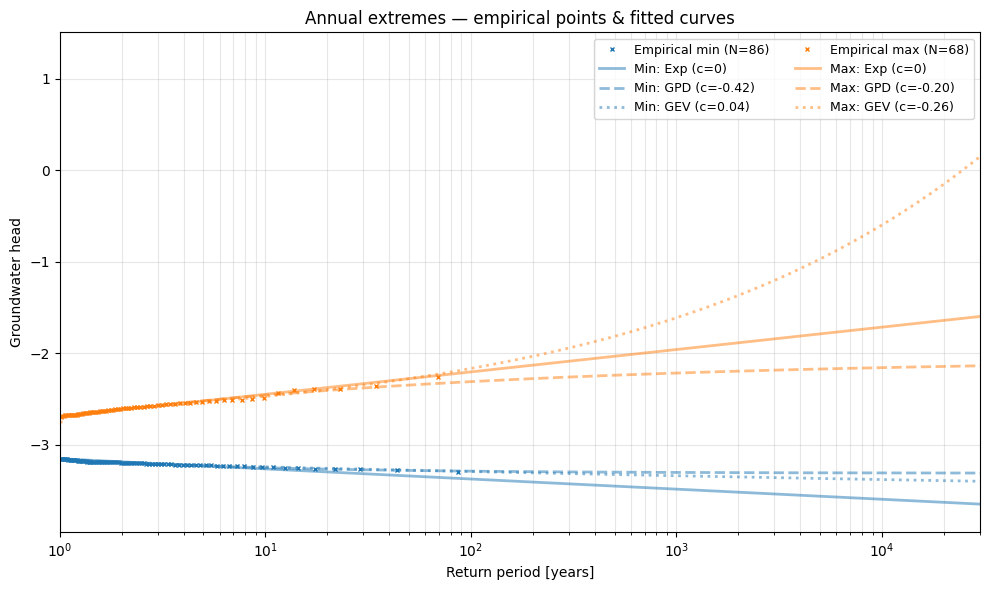

In [20]:
# ==== Usage ====
plot_return_period_right(df_annual_drought, df_annual_wet, col_min="head_min", col_max="head_max")

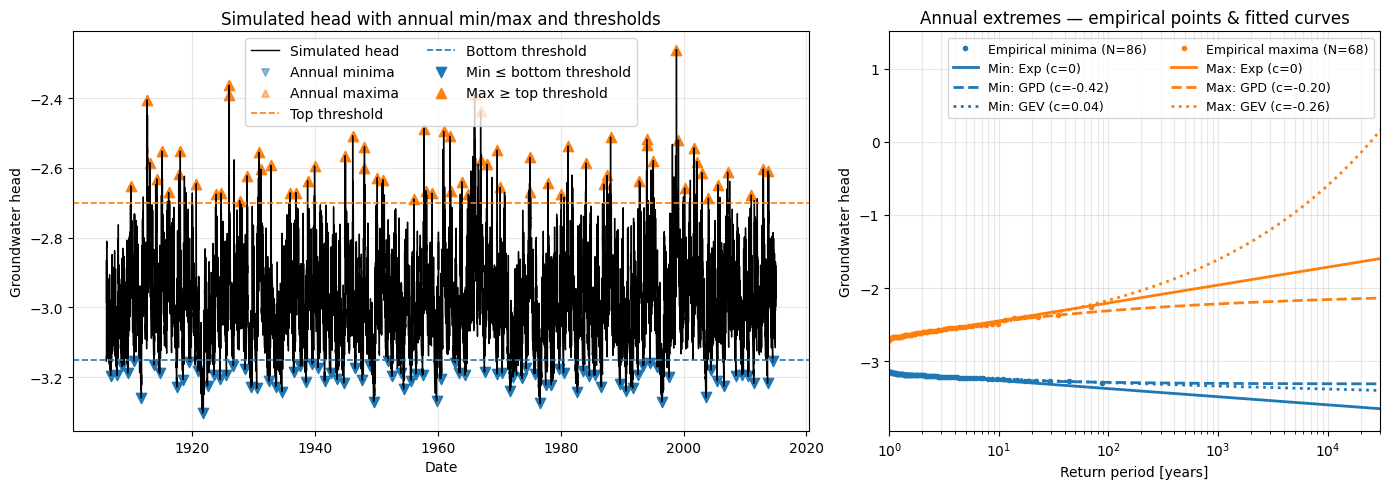

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto, genextreme

# # ----------------- configure thresholds here -----------------
# top_threshold = 0.50      # maxima >= this line highlighted
# bottom_threshold = -0.25  # minima <= this line highlighted
# # -------------------------------------------------------------

# ---------- helpers ----------
def clean_series(s, name="series"):
    if isinstance(s, pd.DataFrame) and s.shape[1] == 1:
        s = s.iloc[:, 0]
    if not isinstance(s, pd.Series):
        raise TypeError(f"{name} must be a Series or 1-col DataFrame")
    s = pd.to_numeric(s, errors="coerce").dropna()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    return s.sort_index()

def annual_min_max(sim: pd.Series):
    grp = sim.groupby(pd.Grouper(freq="Y"))
    idx_min = grp.apply(pd.Series.idxmin)
    idx_max = grp.apply(pd.Series.idxmax)
    df_min = pd.DataFrame({"head_min": sim.loc[idx_min.values].values}, index=idx_min.values)
    df_max = pd.DataFrame({"head_max": sim.loc[idx_max.values].values}, index=idx_max.values)
    df_min["year"] = df_min.index.year
    df_max["year"] = df_max.index.year
    return df_min.sort_index(), df_max.sort_index()

def rp_weibull(n: int) -> np.ndarray:
    """Weibull plotting position: P = k/(n+1), so T = 1/P (years)."""
    k = np.arange(1, n + 1, dtype=float)
    P = k / (n + 1.0)
    return 1.0 / P

def plot_empirical_and_fits_min(ax, mins, color="tab:blue", label_prefix="Min"):
    """Empirical minima + fitted Exp/GPD/GEV (minima treated as lower tail)."""
    y = pd.to_numeric(mins, errors="coerce").dropna().values
    if y.size < 5:
        raise ValueError("Need at least 5 annual minima.")
    # Sort by extremeness: lower = more extreme
    y_sort = np.sort(y)                # ascending heads
    T_emp = rp_weibull(len(y_sort))    # align with order

    # Flip to model lower tail as upper tail
    z = -y_sort
    z0 = z.min()
    f_grid = np.exp(np.linspace(np.log(1e-5), 0, 400))
    T_grid = 1.0 / f_grid

    # Exponential (GPD c=0) with loc=z0
    scale_exp = (z - z0).mean()
    v_exp = -genpareto.ppf(1 - f_grid, c=0.0, loc=z0, scale=scale_exp)

    # GPD (loc fixed to z0)
    c_gpd, loc_gpd, scale_gpd = genpareto.fit(z, floc=z0)
    v_gpd = -genpareto.ppf(1 - f_grid, c=c_gpd, loc=loc_gpd, scale=scale_gpd)

    # GEV (unconstrained)
    c_gev, loc_gev, scale_gev = genextreme.fit(z)
    v_gev = -genextreme.ppf(1 - f_grid, c=c_gev, loc=loc_gev, scale=scale_gev)

    # Plot
    ax.plot(T_emp, y_sort, "o", ms=3, color=color, label=f"Empirical minima (N={len(y_sort)})")
    ax.plot(T_grid, v_exp, color=color, lw=2, label=f"{label_prefix}: Exp (c=0)")
    ax.plot(T_grid, v_gpd, color=color, lw=2, ls="--", label=f"{label_prefix}: GPD (c={c_gpd:.2f})")
    ax.plot(T_grid, v_gev, color=color, lw=2, ls=":",  label=f"{label_prefix}: GEV (c={c_gev:.2f})")

def plot_empirical_and_fits_max(ax, maxs, color="tab:orange", label_prefix="Max"):
    """Empirical maxima + fitted Exp/GPD/GEV (upper tail)."""
    y = pd.to_numeric(maxs, errors="coerce").dropna().values
    if y.size < 5:
        raise ValueError("Need at least 5 annual maxima.")
    # Sort by extremeness: higher = more extreme
    y_sort = np.sort(y)[::-1]          # descending heads
    T_emp = rp_weibull(len(y_sort))

    # Upper tail as-is
    z = y_sort
    z0 = z.min()
    f_grid = np.exp(np.linspace(np.log(1e-5), 0, 400))
    T_grid = 1.0 / f_grid

    # Exponential (GPD c=0) with loc=z0
    scale_exp = (z - z0).mean()
    v_exp = genpareto.ppf(1 - f_grid, c=0.0, loc=z0, scale=scale_exp)

    # GPD (loc fixed to z0)
    c_gpd, loc_gpd, scale_gpd = genpareto.fit(z, floc=z0)
    v_gpd = genpareto.ppf(1 - f_grid, c=c_gpd, loc=loc_gpd, scale=scale_gpd)

    # GEV (unconstrained)
    c_gev, loc_gev, scale_gev = genextreme.fit(z)
    v_gev = genextreme.ppf(1 - f_grid, c=c_gev, loc=loc_gev, scale=scale_gev)

    # Plot
    ax.plot(T_emp, y_sort, "o", ms=3, color=color, label=f"Empirical maxima (N={len(y_sort)})")
    ax.plot(T_grid, v_exp, color=color, lw=2, label=f"{label_prefix}: Exp (c=0)")
    ax.plot(T_grid, v_gpd, color=color, lw=2, ls="--", label=f"{label_prefix}: GPD (c={c_gpd:.2f})")
    ax.plot(T_grid, v_gev, color=color, lw=2, ls=":",  label=f"{label_prefix}: GEV (c={c_gev:.2f})")

def plot_both_panels(simulated: pd.Series,
                     df_annual_drought: pd.DataFrame | None = None,
                     df_annual_wet: pd.DataFrame | None = None,
                     col_min="head_min", col_max="head_max",
                     top_thr=top_threshold, bot_thr=bottom_threshold):
    """
    Left: time series + annual min/max + threshold lines (highlight points crossing thresholds).
    Right: return-period panel with empirical points and fitted curves for minima & maxima.
    """
    sim = clean_series(simulated, "simulated")

    # Build annual extremes if not provided
    if df_annual_drought is None or df_annual_wet is None:
        df_annual_drought, df_annual_wet = annual_min_max(sim)

    mins = pd.to_numeric(df_annual_drought[col_min], errors="coerce").dropna()
    maxs = pd.to_numeric(df_annual_wet[col_max], errors="coerce").dropna()

    # Figure
    fig, (ax_left, ax_right) = plt.subplots(
        1, 2, figsize=(14, 5), gridspec_kw={"width_ratios": [1.5, 1]}, sharey=False
    )

    # -------- Left panel: time series + thresholds --------
    ax_left.plot(sim.index, sim.values, color="black", lw=1.0, label="Simulated head")

    # All annual extrema
    ax_left.scatter(df_annual_drought.index, mins.values, marker="v", s=28,
                    color="tab:blue", alpha=0.5, label="Annual minima")
    ax_left.scatter(df_annual_wet.index, maxs.values, marker="^", s=28,
                    color="tab:orange", alpha=0.5, label="Annual maxima")

    # Threshold lines
    ax_left.axhline(y=top_thr,    color="tab:orange", linestyle="--", linewidth=1.2, label="Top threshold")
    ax_left.axhline(y=bot_thr,    color="tab:blue",   linestyle="--", linewidth=1.2, label="Bottom threshold")

    # Highlight points that cross thresholds
    sel_min = mins <= bot_thr
    sel_max = maxs >= top_thr
    ax_left.scatter(mins.index[sel_min], mins[sel_min], marker="v", s=55, color="tab:blue",
                    label="Min ≤ bottom threshold")
    ax_left.scatter(maxs.index[sel_max], maxs[sel_max], marker="^", s=55, color="tab:orange",
                    label="Max ≥ top threshold")

    ax_left.set_title("Simulated head with annual min/max and thresholds")
    ax_left.set_xlabel("Date")
    ax_left.set_ylabel("Groundwater head")
    ax_left.grid(alpha=0.3)
    ax_left.legend(ncol=2)

    # -------- Right panel: return periods + fits --------
    plot_empirical_and_fits_min(ax_right, mins, color="tab:blue",   label_prefix="Min")
    plot_empirical_and_fits_max(ax_right, maxs, color="tab:orange", label_prefix="Max")
    ax_right.set_xscale("log")
    ax_right.set_xlim(1, 30000)
    ax_right.set_xlabel("Return period [years]")
    ax_right.set_ylabel("Groundwater head")
    ax_right.set_title("Annual extremes — empirical points & fitted curves")
    ax_right.grid(alpha=0.3, which="both")
    ax_right.legend(ncol=2, fontsize=9)

    plt.tight_layout()
    plt.show()

    # Return useful pieces if needed downstream
    return {
        "df_annual_drought": df_annual_drought,
        "df_annual_wet": df_annual_wet,
    }

# ================== Usage ==================
out = plot_both_panels(simulated, df_annual_drought, df_annual_wet,
                       col_min="head_min", col_max="head_max",
                       top_thr=top_threshold, bot_thr=bottom_threshold)


In [17]:
import numpy as np
import pandas as pd
from scipy.stats import genpareto, genextreme
from scipy.interpolate import interp1d

def _weibull_T(n: int) -> np.ndarray:
    """Weibull plotting position -> return period T=1/P."""
    k = np.arange(1, n + 1, dtype=float)
    P = k / (n + 1.0)
    return 1.0 / P

def _empirical_curve_min(mins: pd.Series):
    """Empirical return curve for minima (lower = more extreme)."""
    y = pd.to_numeric(mins, errors="coerce").dropna().values
    y_sort = np.sort(y)                # ascending heads
    T_emp = _weibull_T(len(y_sort))    # same order
    # log-interp in T for smooth query
    f = interp1d(np.log(T_emp), y_sort, fill_value="extrapolate")
    return lambda Tq: f(np.log(np.asarray(Tq, float)))

def _empirical_curve_max(maxs: pd.Series):
    """Empirical return curve for maxima (higher = more extreme)."""
    y = pd.to_numeric(maxs, errors="coerce").dropna().values
    y_sort = np.sort(y)[::-1]          # descending heads
    T_emp = _weibull_T(len(y_sort))
    f = interp1d(np.log(T_emp), y_sort, fill_value="extrapolate")
    return lambda Tq: f(np.log(np.asarray(Tq, float)))

def _fit_min_models(mins: pd.Series):
    """Fit Exp/GPD/GEV to minima (flip sign). Return callables head(T)."""
    y = pd.to_numeric(mins, errors="coerce").dropna().values
    z = -np.sort(y)  # flip; upper tail
    z0 = z.min()
    # Exponential (GPD c=0) with loc fixed to min
    scale_exp = (z - z0).mean()
    def exp_head(T):  # head at return period T
        f = np.minimum(1 - 1e-12, 1.0 / np.asarray(T, float))
        return -genpareto.ppf(1 - f, c=0.0, loc=z0, scale=scale_exp)

    # GPD with loc fixed to z0
    c_gpd, loc_gpd, scale_gpd = genpareto.fit(z, floc=z0)
    def gpd_head(T):
        f = np.minimum(1 - 1e-12, 1.0 / np.asarray(T, float))
        return -genpareto.ppf(1 - f, c=c_gpd, loc=loc_gpd, scale=scale_gpd)

    # GEV (unconstrained) on z
    c_gev, loc_gev, scale_gev = genextreme.fit(z)
    def gev_head(T):
        f = np.minimum(1 - 1e-12, 1.0 / np.asarray(T, float))
        return -genextreme.ppf(1 - f, c=c_gev, loc=loc_gev, scale=scale_gev)

    return exp_head, gpd_head, gev_head, (0.0, z0, scale_exp), (c_gpd, loc_gpd, scale_gpd), (c_gev, loc_gev, scale_gev)

def _fit_max_models(maxs: pd.Series):
    """Fit Exp/GPD/GEV to maxima (upper tail as-is). Return callables head(T)."""
    y = pd.to_numeric(maxs, errors="coerce").dropna().values
    z = np.sort(y)[::-1]
    z0 = z.min()
    # Exponential (GPD c=0)
    scale_exp = (z - z0).mean()
    def exp_head(T):
        f = np.minimum(1 - 1e-12, 1.0 / np.asarray(T, float))
        return genpareto.ppf(1 - f, c=0.0, loc=z0, scale=scale_exp)

    # GPD with loc fixed
    c_gpd, loc_gpd, scale_gpd = genpareto.fit(z, floc=z0)
    def gpd_head(T):
        f = np.minimum(1 - 1e-12, 1.0 / np.asarray(T, float))
        return genpareto.ppf(1 - f, c=c_gpd, loc=loc_gpd, scale=scale_gpd)

    # GEV
    c_gev, loc_gev, scale_gev = genextreme.fit(z)
    def gev_head(T):
        f = np.minimum(1 - 1e-12, 1.0 / np.asarray(T, float))
        return genextreme.ppf(1 - f, c=c_gev, loc=loc_gev, scale=scale_gev)

    return exp_head, gpd_head, gev_head, (0.0, z0, scale_exp), (c_gpd, loc_gpd, scale_gpd), (c_gev, loc_gev, scale_gev)

def heads_at_return_periods(df_annual_drought: pd.DataFrame,
                            df_annual_wet: pd.DataFrame,
                            T_list=(1, 3, 10, 30, 100, 300, 1000),
                            col_min="head_min", col_max="head_max") -> pd.DataFrame:
    """
    Compute groundwater head at specified return periods (years) for drought & wet,
    using Exp / GPD / GEV fits and empirical interpolation.
    Returns a DataFrame indexed by T with columns:
      ['min_exp','min_gpd','min_gev','min_emp','max_exp','max_gpd','max_gev','max_emp'].
    """
    if col_min not in df_annual_drought.columns:
        raise KeyError(f"'{col_min}' not in df_annual_drought")
    if col_max not in df_annual_wet.columns:
        raise KeyError(f"'{col_max}' not in df_annual_wet")

    mins = df_annual_drought[col_min]
    maxs = df_annual_wet[col_max]

    # fit parametric models
    min_exp, min_gpd, min_gev, _, _, _ = _fit_min_models(mins)
    max_exp, max_gpd, max_gev, _, _, _ = _fit_max_models(maxs)

    # empirical interpolants
    min_emp_f = _empirical_curve_min(mins)
    max_emp_f = _empirical_curve_max(maxs)

    T_arr = np.asarray(T_list, float)

    out = pd.DataFrame(index=T_arr, columns=[
        "dr_exp","dr_gpd","dr_gev","dr_emp",
        "wet_exp","wet_gpd","wet_gev","wet_emp"
    ], dtype=float)

    out["dr_exp"] = min_exp(T_arr)
    out["dr_gpd"] = min_gpd(T_arr)
    out["dr_gev"] = min_gev(T_arr)
    out["dr_emp"] = min_emp_f(T_arr)

    out["wet_exp"] = max_exp(T_arr)
    out["wet_gpd"] = max_gpd(T_arr)
    out["wet_gev"] = max_gev(T_arr)
    out["wet_emp"] = max_emp_f(T_arr)

    out.index.name = "Return period [years]"
    return out.sort_index()

In [18]:
T_list = [1, 3, 10, 30, 100, 300, 1000]
table = heads_at_return_periods(df_annual_drought, df_annual_wet, T_list=T_list,
                                col_min="head_min", col_max="head_max")
print(table)

                         dr_exp    dr_gpd    dr_gev    dr_emp   wet_exp  \
Return period [years]                                                     
1.0                   -3.154217 -3.154217 -3.099382 -3.153942 -2.694152   
3.0                   -3.207086 -3.212828 -3.210996 -3.210399 -2.577335   
10.0                  -3.265026 -3.252501 -3.242790 -3.241637 -2.449315   
30.0                  -3.317896 -3.274781 -3.268231 -3.270304 -2.332498   
100.0                 -3.375836 -3.289862 -3.294242 -3.307785 -2.204478   
300.0                 -3.428705 -3.298332 -3.316735 -3.350983 -2.087661   
1000.0                -3.486645 -3.304065 -3.340212 -3.398323 -1.959641   

                        wet_gpd   wet_gev   wet_emp  
Return period [years]                                
1.0                   -2.694152 -2.748811 -2.698913  
3.0                   -2.568621 -2.580137 -2.570156  
10.0                  -2.459206 -2.473168 -2.482538  
30.0                  -2.379862 -2.348643 -2.372255  
